In [2]:
import tensorflow as tf
import os
import numpy as np
import imghdr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/data"
IMG_SIZE = 160
BATCH_SIZE = 32


print("Scanning dataset...")
image_paths = []
labels = []


all_folders = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])

for sid in all_folders:
    folder_path = os.path.join(DATASET_DIR, sid)

    for fn in os.listdir(folder_path):
        file_path = os.path.join(folder_path, fn)


        if not fn.lower().endswith((".jpg", ".jpeg", ".png")):
            continue


        try:
            if imghdr.what(file_path) is None:
                continue

            image_paths.append(file_path)
            labels.append(sid)
        except:
            continue

print(f"Found {len(image_paths)} valid images in {len(all_folders)} classes.")


le = LabelEncoder()
y_encoded = le.fit_transform(labels)
NUM_CLASSES = len(le.classes_)


X_train, X_test, y_train, y_test = train_test_split(
    np.array(image_paths), y_encoded,
    test_size=0.2, random_state=42, stratify=y_encoded
)


AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3, try_recover_truncated=True)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.one_hot(label, NUM_CLASSES)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (train_ds.shuffle(2000)
            .map(load_image, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = (val_ds.map(load_image, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

print("Data pipeline ready.")

Scanning dataset...
Found 1875 valid images in 104 classes.
Data pipeline ready.


In [3]:

base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False


inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)

x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 88)             │       112,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,370,712 (9.04 MB)

 Trainable params: 112,728 (440.34 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 438s 9s/step - accuracy: 0.1498 - loss: 4.3330 - val_accuracy: 0.7920 - val_loss: 1.3837 - learning_rate: 0.0010
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8208 - loss: 1.0517 - val_accuracy: 0.9013 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9359 - loss: 0.4567 - val_accuracy: 0.9173 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9757 - loss: 0.2453 - val_accuracy: 0.9413 - val_loss: 0.3330 - learning_rate: 0.0010
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9836 - loss: 0.1562 - val_accuracy: 0.9253 - val_loss: 0.2965 - learning_rate: 0.0010
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9971 - loss: 0.1013 - val_accuracy: 0.9413 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9982 - loss: 0.0828 - val_accuracy:

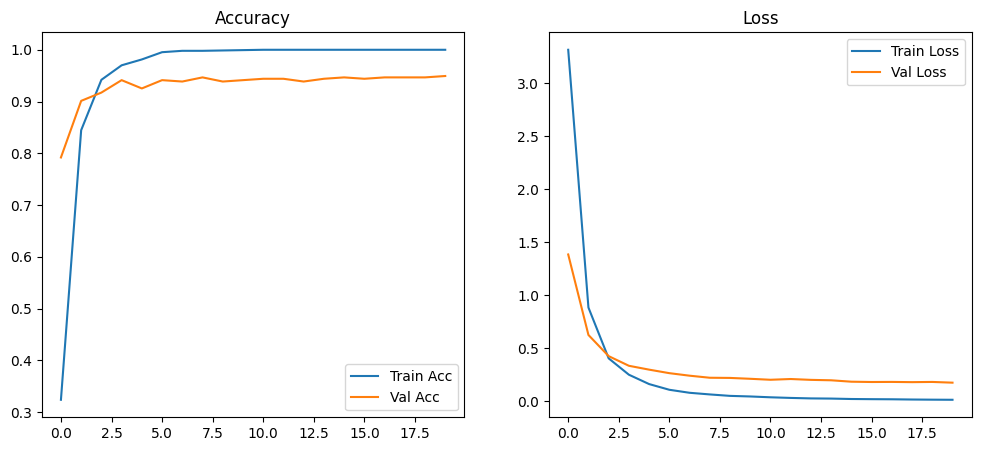


 Checking 6 Random Test Images...


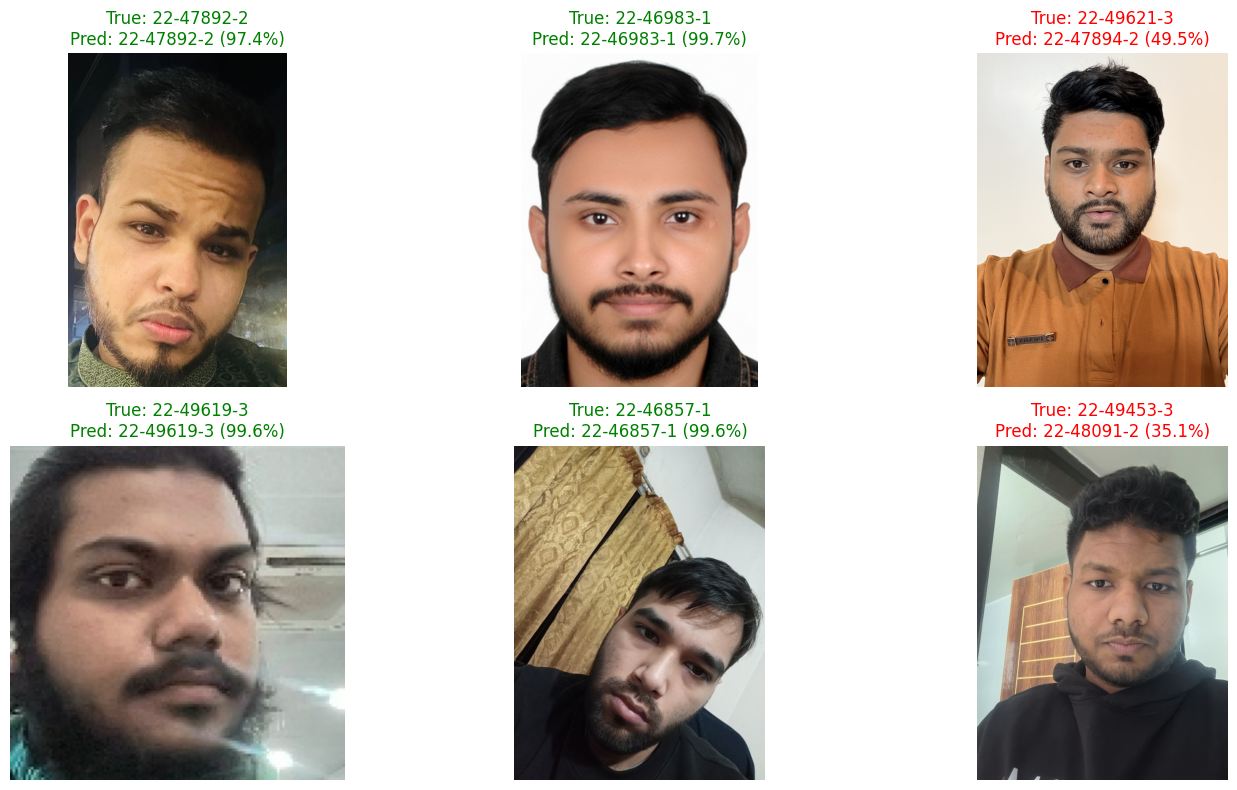

In [7]:
import matplotlib.pyplot as plt
import cv2
import random

# 1. Plot Graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


print("\n Checking 6 Random Test Images...")
plt.figure(figsize=(15, 8))
sample_indices = random.sample(range(len(X_test)), 6)

for i, idx in enumerate(sample_indices):
    path = X_test[idx]
    true_label = le.inverse_transform([y_test[idx]])[0]


    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized.astype(np.float32) / 255.0
    img_batch = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_batch, verbose=0)
    pred_idx = np.argmax(pred)
    conf = np.max(pred)
    pred_label = le.classes_[pred_idx]

    color = 'green' if true_label == pred_label else 'red'

    plt.subplot(2, 3, i+1)
    plt.imshow(img_rgb)
    plt.title(f"True: {true_label}\nPred: {pred_label} ({conf:.1%})", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
import pickle
from google.colab import files


model.save("friend_face_model.h5")


with open("friend_labels.pkl", "wb") as f:
    pickle.dump(le, f)

print(" Files saved successfully.")
print("⬇ Downloading now...")

files.download("friend_face_model.h5")
files.download("friend_labels.pkl")

 Files saved successfully.
⬇ Downloading now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>